In [ ]:
!pip install googletrans==3.1.0-alpha
!pip install langdetect
!pip install transformers

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16351 sha256=95bb7daa59e7dab438aaddcdd2f322618a0309f95e028f90997a213d52a037cc
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling c

In [ ]:
import pandas as pd
import json
import torch
from torch.utils.data import Dataset
import string
from googletrans import Translator
from langdetect import detect


CLASSES_OF_INTEREST = [
    'translate',
    'travel_alert',
    'flight_status',
    'lost_luggage', # /!\ to this class
    'travel_suggestion',
    'carry_on',
    'book_flight',
    'book_hotel',
    'oos', # might be removed because a binary classification problem
]

class CLNIC150(Dataset):
    def __init__(self, path, set = 'train'):
        super().__init__()
        self.set = set
        self.path = path
        self.prompts, self.intents = self._read_clinc()

    def __len__(self):
        return len(self.prompt)

    def __getitem__(self, idx):
        return self.prompt[idx], self.intent[idx]

    def _read_clinc(self):

        #Load CLINC150 dataset from JSON file
        #Json from https://github.com/clinc/oos-eval/tree/master/data

        with open(self.path, 'r') as f:
            data = json.load(f)

        data = data[self.set] + data['oos_' + self.set]

        prompts = []
        intents = []

        for row in data:
            prompts.append(row[0])
            intents.append(row[1])

        return prompts, intents

    def _get_classes_of_interest(self, classes_of_interest: list = CLASSES_OF_INTEREST):
        #corpus.intent is a list
        interest_index = []
        for i, intent in enumerate(self.intents):
            if intent in classes_of_interest:
                interest_index.append(i)

        self.intents = [self.intents[i] for i in interest_index]
        self.prompts = [self.prompts[i] for i in interest_index]
        return self.prompts, self.intents

class BertDataset(Dataset):
    def __init__(self, prompts, intents, tokenizer, max_length):
        super().__init__()
        #Preprocess the inputs prompts
        self.prompts = [self._preprocess(prompt) for prompt in prompts]

        #Convert intents to numeric labels
        self.labels_dict = {label: i for i, label in enumerate(set(intents))}
        self.intents = [self.labels_dict[intent] for intent in intents]

        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        prompt = self.prompts[idx]
        intent = self.intents[idx]

        encoding = self.tokenizer(
            prompt,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'prompt': prompt,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'intent': torch.tensor(intent, dtype=torch.long)
        }

    def _lower(self, text):
        return text.lower()

    def _remove_punctuation(self, text):
        table = str.maketrans('', '', string.punctuation)
        return text.translate(table)

    def _translate(self, text):
        lang = detect(text)
        if lang != 'en':
            translator = Translator()
            text = translator.translate(text, dest='en', str = 'auto').text
        return text

    def _preprocess(self, text):
        text = self._translate(text)
        text = self._lower(text)
        text = self._remove_punctuation(text)
        return text

In [ ]:
from torch import nn
from transformers import BertTokenizer, BertModel

class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes, freeze_bert = True):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        #Add a fully-connected layer to the bert model for classification
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.dropout(output.pooler_output)
        logits = self.fc(output)
        return logits

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

def train(model, train_dataset, val_dataset, device, batch_size, epochs, lr, patience):
    # Set up optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Set up data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    counter = 0

    # Train the model
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['intent'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(1).cpu()
            labels = labels.cpu()

            train_loss += loss.item()
            train_acc += accuracy_score(labels, preds)

            avg_train_loss = train_loss/(len(train_loader.dataset)/batch_size)
            avg_train_acc = train_acc/(len(train_loader.dataset)/batch_size)

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)


        # Evaluate the model on the val set
        model.eval()
        val_loss = 0
        val_acc = 0
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['intent'].to(device)

                outputs = model(input_ids, attention_mask)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(1).cpu()
                val_acc += accuracy_score(labels.cpu(), preds)

                val_preds.extend(preds)
                val_labels.extend(labels.cpu())

                avg_val_loss = val_loss/(len(val_loader.dataset)/batch_size)
                avg_val_acc = val_acc/(len(val_loader.dataset)/batch_size)

        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)
        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')

        # Check if early stopping conditions are met
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print('Early stopping triggered.')
                epochs = epoch +1
                break

   # Print classification report
    print(classification_report(val_labels, val_preds))

    # Plot training and validation metrics
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

In [ ]:
path = '/content/data_full.json'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clinc_train = CLNIC150(path, set= 'train')
x_train, y_train = clinc_train._get_classes_of_interest(classes_of_interest= CLASSES_OF_INTEREST)

clinc_val = CLNIC150(path, set= 'val')
x_val, y_val = clinc_val._get_classes_of_interest(classes_of_interest= CLASSES_OF_INTEREST)

bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_dataset = BertDataset(x_train, y_train, tokenizer, max_length= 128)
val_dataset = BertDataset(x_val, y_val, tokenizer, max_length= 128)


In [ ]:
train_dataset.labels_dict

{'travel_alert': 0,
 'travel_suggestion': 1,
 'carry_on': 2,
 'book_hotel': 3,
 'oos': 4,
 'translate': 5,
 'flight_status': 6,
 'lost_luggage': 7,
 'book_flight': 8}

Epoch 1/500: Train Loss: 2.2782, Train Acc: 0.1211, Val Loss: 2.4146, Val Acc: 0.1692
Epoch 2/500: Train Loss: 2.2277, Train Acc: 0.1767, Val Loss: 2.3405, Val Acc: 0.2923
Epoch 3/500: Train Loss: 2.1797, Train Acc: 0.2189, Val Loss: 2.2967, Val Acc: 0.3308
Epoch 4/500: Train Loss: 2.1592, Train Acc: 0.2444, Val Loss: 2.2910, Val Acc: 0.1885
Epoch 5/500: Train Loss: 2.1427, Train Acc: 0.2389, Val Loss: 2.2553, Val Acc: 0.3269
Epoch 6/500: Train Loss: 2.1212, Train Acc: 0.2933, Val Loss: 2.2230, Val Acc: 0.4000
Epoch 7/500: Train Loss: 2.0758, Train Acc: 0.3233, Val Loss: 2.2291, Val Acc: 0.3538
Epoch 8/500: Train Loss: 2.0847, Train Acc: 0.2756, Val Loss: 2.2081, Val Acc: 0.3615
Epoch 9/500: Train Loss: 2.0750, Train Acc: 0.3167, Val Loss: 2.1489, Val Acc: 0.4231
Epoch 10/500: Train Loss: 2.0159, Train Acc: 0.3744, Val Loss: 2.1145, Val Acc: 0.4038
Epoch 11/500: Train Loss: 2.0155, Train Acc: 0.3667, Val Loss: 2.1303, Val Acc: 0.4308
Epoch 12/500: Train Loss: 1.9874, Train Acc: 0.3856,

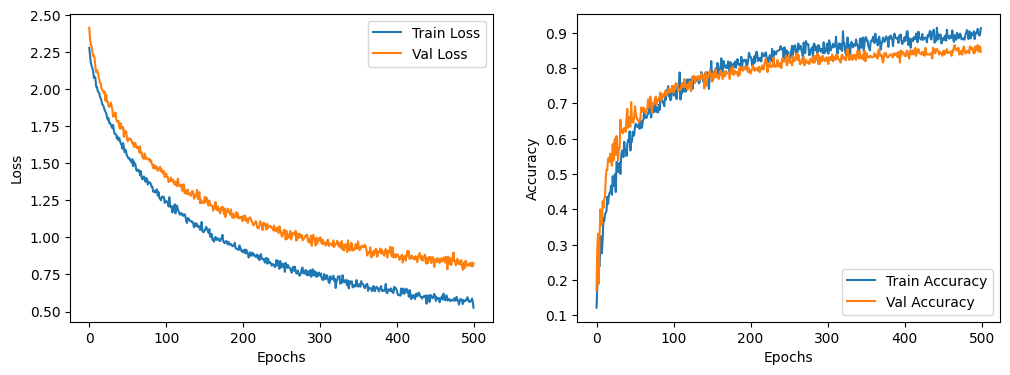

In [ ]:
train(BERTClassifier(bert_model_name, num_classes= 9).to(device),
      train_dataset, val_dataset, device,
      batch_size = 32, epochs =500, lr = 2e-4, patience = 50)